This notebook calculate g2 for each spatial pixel to create r-resolved relaxation time

In [1]:
import hyperspy.api as hs
import numpy as np
import matplotlib.pyplot as plt
import SeqIO

In [2]:
%matplotlib notebook

In [3]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=4,
                      threads_per_worker=4,
                      dashboard_address=':8705')
cluster.scale(4)
client = Client(cluster)

In [6]:
import dask.array as da

In [7]:
strip_reg = hs.signals.Signal2D(da.from_zarr('strip_reg_rec.zarr')).as_lazy().transpose(navigation_axes=[1,2])

In [33]:
strip_reg

<LazySignal, title: , dimensions: (160, 160|160, 15, 500)>

In [18]:
mean_electron = strip_reg.inav[60:85,60:85].mean(axis=(-1,-3))

In [19]:
mean_electron.compute()

In [20]:
mean_electron.mean().data

array([0.26579022, 0.46602187, 0.49284643, 0.5351858 , 0.59084016,
       0.6479986 , 0.69436634, 0.7201933 , 0.71576536, 0.6835577 ,
       0.63057446, 0.56162125, 0.496064  , 0.4432525 , 0.26473624],
      dtype=float32)

In [22]:
strip_exp = strip_reg.inav[20:25,20:25].isig[:,:,:200]

In [23]:
strip_exp.compute()

<IPython.core.display.Javascript object>


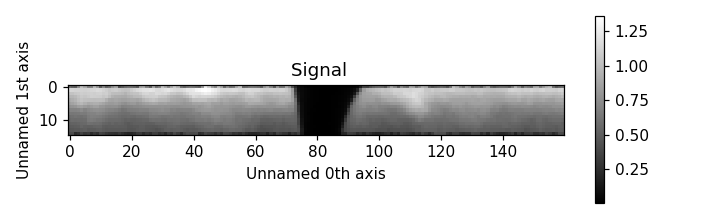

In [24]:
strip_exp.mean(axis=(0,1,-1)).plot()

In [25]:
from scipy.optimize import curve_fit
from scipy import signal

In [27]:
def get_g2_2d_averaged(data,normalization='split',bs=None,kbin=1,tbin=1):
    # returns k-average g2(t) form I(k_r,k_phi,t)
    # bs: [left,right] k_phi for the beamstop
    # kbin, tbin: binning factor for k and t
    data = data.T
    data = data.reshape((data.shape[0]//kbin),kbin, (data.shape[1]//kbin),kbin, (data.shape[2]//tbin), tbin).sum(5).sum(3).sum(1)
    acorr = signal.fftconvolve(data,data[:,:,::-1],mode='full',axes=[-1])
    norm = signal.fftconvolve(np.ones(data.shape),data[:,:,::-1],mode='full',axes=[-1])
    if normalization == 'self':
        g2 = acorr[:,:,data.shape[-1]-1:]/norm[:,:,data.shape[-1]:0:-1]**2*np.expand_dims(np.linspace(data.shape[-1],1,data.shape[-1]), axis=(0, 1))
    if normalization == 'split':
        g2 = acorr[:,:,data.shape[-1]-1:]/norm[:,:,data.shape[-1]-1:]/norm[:,:,::-1][:,:,data.shape[-1]-1:]*np.expand_dims(np.linspace(data.shape[-1],1,data.shape[-1]), axis=(0, 1))
    
    if bs is not None:
        return np.mean(g2[:bs[0]//kbin],axis=(0,1))/2 + np.mean(g2[bs[1]//kbin:],axis=(0,1))/2
    else:
        return np.mean(g2,axis=(0,1))

In [28]:
def t_resampled(t_size,dt,t_rs_size):
    # returns resampled time array that evenly samples the log space
    # t_size: length of time array
    # dt: time intervals
    # t_rs_size: length of resampled time array
    t_rs = np.zeros(t_rs_size, dtype = np.float)
    
    for i in range(t_rs_size):
        t_rs[i] = np.power(10, np.log10(dt) + np.log10(t_size - 1)*i/(t_rs_size - 1))
        
    return t_rs

In [29]:
def g2_windowed_resampled(g2w,t_rs,dt):
    # returns g2(t) with resampled times
    # g2w: g2(t) in linear time
    # t_rs: resampled time array
    # dt: time intervals
    t = np.round(t_rs/dt,8)
    g2_l = g2w[np.floor(t).astype(int)]
    g2_h = g2w[np.ceil(t).astype(int)]
    g2_rs = g2_l + (g2_h - g2_l) * (t - np.floor(t).astype(int))
    return g2_rs

In [30]:
def KWW_curve(t, tau, beta, C):
    return C*np.exp(-2*np.power((t/tau),beta))+1

In [31]:
def KWW_fitting(g2_rs,t_rs,tau_guess):
    # return fitting parameters tau, beta and C for KWW function
    # g2_rs: g2(t) with resampled times
    # t_rs: resampled time array
    # tau_guess: guess for parameter tau
    
    lim = g2_rs[0]-1
    indices = np.logical_and(~np.isnan(g2_rs),np.abs(g2_rs-1)<=lim)
    try:
        popt, pcov = curve_fit(KWW_curve, t_rs[indices], g2_rs[indices], p0 = [tau_guess,1,lim],bounds=([.1,0.1,lim/2],[200,10,10*lim]))
        return popt
    except:
        return [0,0,0]

### Calculate k-averaged g2(t)

In [35]:
g2wm = strip_reg.isig[:,:-1].map(get_g2_2d_averaged,kbin=2,bs=[70,95],inplace=False)
trs = t_resampled(500,3.2,50)
g2rs = g2wm.map(g2_windowed_resampled,t_rs=trs,dt=3.2,inplace=False)

/srv/home/syhuang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [36]:
g2rs.compute()

In [37]:
g2rs.save('results/g2_full.hspy',chunks=(10,10,50))

In [38]:
del g2rs

### Obtain r-resolved relaxation time by fitting KWW function

In [39]:
g2 = hs.load('results/g2_full.hspy',lazy=True)
tbmap = g2.map(KWW_fitting,t_rs=t_resampled(500,3.2,50),tau_guess=20,inplace=False)

/srv/home/syhuang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [40]:
tbmap.compute()

<IPython.core.display.Javascript object>


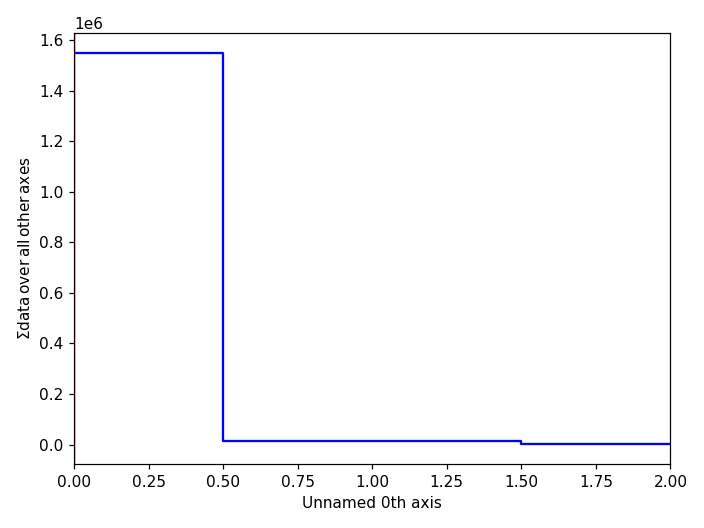

<IPython.core.display.Javascript object>


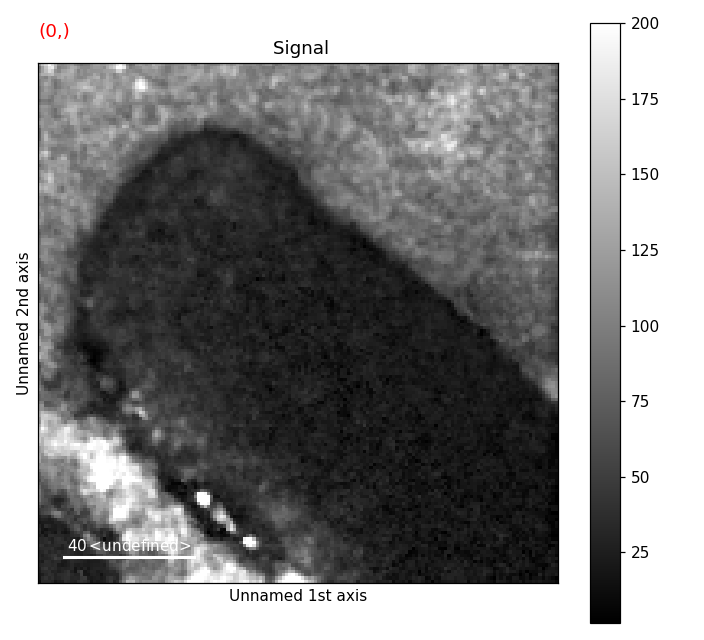

In [41]:
tbmap.T.plot()

In [42]:
reg = np.load('reg_ref.npy')

In [238]:
tbmap = hs.load('results/tb_19600fps.hspy')

In [43]:
tbmap

<Signal1D, title: , dimensions: (160, 160|3)>

<IPython.core.display.Javascript object>


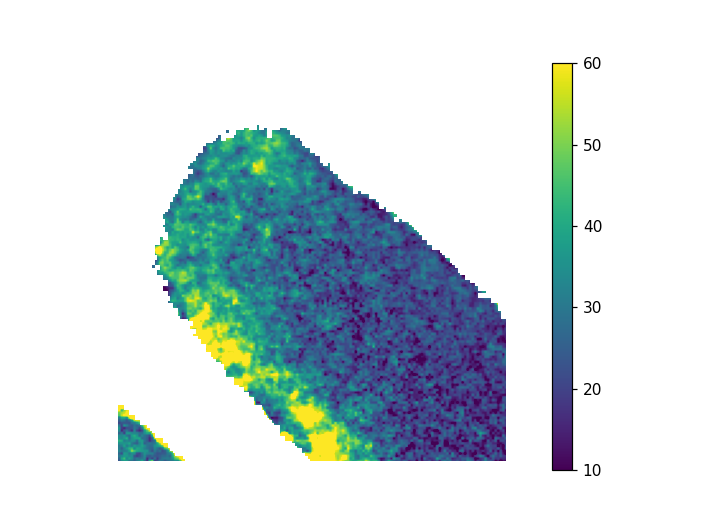

In [49]:
plt.figure()
plt.imshow(np.ma.masked_where(reg<1.8e5,tbmap.T.inav[0].data),vmax=60,vmin=10)
plt.axis('off')
plt.colorbar()
plt.show()

In [51]:
print(np.mean(np.ma.masked_where(reg<1.8e5,tbmap.T.inav[0].data).compressed()))
print(np.mean(np.ma.masked_where(reg<1.8e5,tbmap.T.inav[1].data).compressed()))

30.27484991452575
0.5302462322216583


In [52]:
tbmap.save('tb.hspy',chunks=(20,20,3))